In [1]:
import os
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import json
from panopticapi.utils import rgb2id

BATCH_SIZE = 8
IMG_WIDTH = 128
IMG_HEIGHT = 128

TRAIN_PATH = './COCO/'
TEST_PATH = './COCO/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [2]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, panoptic_json, panoptic_root, img_dir, transforms=None, img_size=(128, 128)):
        self.img_dir = img_dir
        self.panoptic_root = panoptic_root
        self.transforms = transforms
        self.img_width, self.img_height = img_size
        
        with open(panoptic_json, 'r') as f:
            self.panoptic_data = json.load(f)

        self.images = self.panoptic_data["images"]

        self.annotations = {}
        for ann in self.panoptic_data["annotations"]:
            self.annotations[ann["image_id"]] = ann

        self.categories = self.panoptic_data["categories"]

        all_cat_ids = sorted(cat["id"] for cat in self.categories)
        self.cat2label = {cat_id: idx for idx, cat_id in enumerate(all_cat_ids)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        image_id = img_info["id"]
        w, h = img_info["width"], img_info["height"]
        img_filename = img_info["file_name"]  

        img_path = os.path.join(self.img_dir, img_filename)
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Could not find {img_path}")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        ann_info = self.annotations[image_id]
        seg_filename = ann_info["file_name"]  
        seg_path = os.path.join(self.panoptic_root, seg_filename)
        seg_bgr = cv2.imread(seg_path, cv2.IMREAD_COLOR)
        if seg_bgr is None:
            raise FileNotFoundError(f"Could not find {seg_path}")

        seg_rgb = cv2.cvtColor(seg_bgr, cv2.COLOR_BGR2RGB)
        seg_id_map = rgb2id(seg_rgb)  

        semantic_mask = np.zeros((h, w), dtype=np.int32)

        for seg in ann_info["segments_info"]:
            cat_id = seg["category_id"]  
            seg_id = seg["id"]          

            label_id = self.cat2label[cat_id]

            mask_pixels = (seg_id_map == seg_id)
            semantic_mask[mask_pixels] = label_id

        image_rgb = cv2.resize(image_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
        semantic_mask = cv2.resize(semantic_mask, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)

        if self.transforms:
            image_rgb = self.transforms(image_rgb)  

        semantic_mask = torch.from_numpy(semantic_mask).long()

        return image_rgb, semantic_mask

In [3]:
train_dataset = COCOSegmentationDataset(
    panoptic_json=os.path.join(TRAIN_PATH, 'annotations', 'panoptic_train2017.json'),
    panoptic_root=os.path.join(TRAIN_PATH, 'panoptic_train2017'), 
    img_dir=os.path.join(TRAIN_PATH, 'train2017','train2017'),
    transforms=ToTensor(),
    img_size=(IMG_HEIGHT, IMG_WIDTH)
)
val_dataset = COCOSegmentationDataset(
    panoptic_json=os.path.join(TRAIN_PATH,  'annotations', 'panoptic_val2017.json'),
    panoptic_root=os.path.join(TRAIN_PATH, 'panoptic_val2017'), 
    img_dir=os.path.join(TRAIN_PATH, 'val2017'),
    transforms=ToTensor(),
    img_size=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]
    if isinstance(image, torch.Tensor):
        # Permute to [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # If it's in range [0,1], scale for display:
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
    else:
        # If 'image' is already a NumPy array with shape [H, W, C]
        image_np = image
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask)
    plt.title("Mask")

    plt.show()


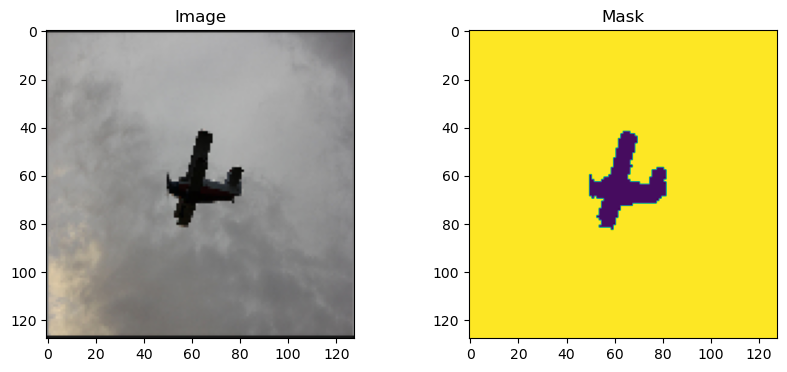

In [5]:
visualize_random_sample(train_dataset)

In [6]:
def mean_iou(y_pred, y_true, num_classes=91):
    y_pred = torch.argmax(y_pred, dim=1)
    iou_list = []

    for class_id in range(num_classes):
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        iou = intersection.float() / (union.float() + 1e-6)
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mask2FormerAttention(nn.Module):
    def __init__(self, channels, size):
        super(Mask2FormerAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.mask = None  

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        if channels != self.channels:
            raise ValueError("Input channel size does not match initialized channel size.")
        
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  

        Q = self.query(x)  
        K = self.key(x)    
        V = self.value(x)  

        scores = torch.matmul(Q, K.transpose(-2, -1))  
        scores = scores / (self.channels ** 0.5)       

        if self.mask is None or self.mask.size(-1) != height * width:
            binary_mask = torch.randint(0, 2, (batch_size, height, width), device=x.device)
            binary_mask = binary_mask.view(batch_size, -1)  
            processed_mask = torch.where(binary_mask > 0.5, torch.tensor(0.0, device=x.device), torch.tensor(-float('inf'), device=x.device))
            self.mask = processed_mask.unsqueeze(1).expand(-1, height * width, -1) 
            
        scores = scores + self.mask

        attention_weights = F.softmax(scores, dim=-1)  
        attention_output = torch.matmul(attention_weights, V) 
        attention_output = attention_output + x  

        return attention_output.view(batch_size, channels, height, width)


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x
    
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = Mask2FormerAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = Mask2FormerAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = Mask2FormerAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = Mask2FormerAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = Mask2FormerAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = Mask2FormerAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        x = self.self_attention6(x)
        output = self.output_conv(x)
        return output


In [9]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')

In [10]:
import torch.backends.cudnn as cudnn
from torch_lr_finder import LRFinder

c_in = 3  # input channel 3 for RGB
c_out = len(train_dataset.cat2label)
print(f'total number of classes used: {c_out}')
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-03)

# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=100)

# lr_finder.plot()

# lr_finder.reset()

early_stopping = EarlyStopping(patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

total number of classes used: 133


/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
# Training loop
num_epochs = 200
max_grad_norm = 1.0
model.to(device1)
best_loss = float("inf")
best_iou = 0.0
log_file = open("training_log_refine9.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            model = model.to(device1)
        # inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        inputs, labels = inputs.to(device1), labels.to(device1)
        # print(inputs.shape)
        # print(labels.shape)
        # print(f"Unique label values: {labels.unique()}")
        optimizer.zero_grad()
        outputs = model(inputs)

        # labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels, c_out)
        # labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")
        # labels = torch.clamp(labels, 0, 20)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 5000 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 2000 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)
    
    if best_iou-avg_iou > 0.1:
        print("Model Overfit")
        break
    
    # scheduler.step()

    torch.save(model.state_dict(), 'epoch.pth')
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
    
# torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')
log_file.close()

  0%|          | 0/14786 [00:00<?, ?it/s]

In [ ]:
model = model.to(device1)
best_val_loss = float("inf")
best_val_iou = 0.0
log_file = open("validating_log_trail1.txt", "w")
for epoch in range(0,num_epochs):
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            # inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
            inputs, labels = inputs.to(device1), labels.to(device1)
            outputs = model(inputs)
            # labels = labels.squeeze(1)
            total_val_iou += mean_iou(outputs, labels,c_out).item()
            # labels = labels.long()
            # labels = labels.long()
            # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")
            # labels = torch.clamp(labels, 0, 20)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    preds_val = outputs

    avg_val_loss = total_val_loss / num_batches
    avg_val_iou = total_val_iou / num_batches

    print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")
    
    best_val_loss = min(best_val_loss,avg_val_loss)
    best_val_iou = max(best_val_iou,avg_val_iou)
    
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_val_loss} IoU: {avg_val_iou}\n")
    log_file.write(f'Best loss: {best_val_loss}, Best IoU: {best_val_iou}\n\n')
    log_file.flush()

print(f'Best Validation loss is {best_val_loss}, best Validation iou is {best_val_iou}')
log_file.close()

In [ ]:
def visualize_predictions(model, dataset, device, idx=0):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[idx]
        image = image.unsqueeze(0).permute(0, 3, 1, 2).to(device)  
        output = model(image)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")

        plt.show()


In [ ]:
test_idx = random.randint(0, len(val_dataset) - 1)
visualize_predictions(model, val_dataset, device1, idx=test_idx)